# Import des librairies

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Définition du chemin du dataset

In [2]:
DATASET_DIR = r"C:\Users\michael\Downloads\archive\A_DeviceMotion_data\A_DeviceMotion_data"

# Liste pour stocker les DataFrames de chaque fichier CSV
all_data = []

# Parcours des dossiers d'activité

In [3]:
# Parcourir chaque dossier d'activité
for activity_folder in os.listdir(DATASET_DIR):
    folder_path = os.path.join(DATASET_DIR, activity_folder)
    if not os.path.isdir(folder_path):
        continue
    
    # Déterminer l'activité à partir du nom du dossier (avant le "_")
    activity = activity_folder.split("_")[0].lower()

    # Parcourir les fichiers CSV à l'intérieur du dossier
    for file in os.listdir(folder_path):
        if file.endswith(".csv"):
            file_path = os.path.join(folder_path, file)
            
            # Charger le fichier CSV
            df = pd.read_csv(file_path)
            
            # Ajouter colonnes : activité + identifiant du fichier
            df["activity"] = activity
            df["file_id"] = file  # identifiant utile
            
            all_data.append(df)

# Concaténer tous les fichiers en un seul dataframe
data = pd.concat(all_data, ignore_index=True)

# Informations sur le dataset

In [4]:
print("Shape du dataset :", data.shape)
print("Colonnes :", data.columns.tolist())
print("Activités :", data["activity"].unique())
print(data.head())

Shape du dataset : (1412865, 15)
Colonnes : ['Unnamed: 0', 'attitude.roll', 'attitude.pitch', 'attitude.yaw', 'gravity.x', 'gravity.y', 'gravity.z', 'rotationRate.x', 'rotationRate.y', 'rotationRate.z', 'userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z', 'activity', 'file_id']
Activités : ['dws' 'jog' 'sit' 'std' 'ups' 'wlk']
   Unnamed: 0  attitude.roll  attitude.pitch  attitude.yaw  gravity.x  \
0           0       1.528132       -0.733896      0.696372   0.741895   
1           1       1.527992       -0.716987      0.677762   0.753099   
2           2       1.527765       -0.706999      0.670951   0.759611   
3           3       1.516768       -0.704678      0.675735   0.760709   
4           4       1.493941       -0.703918      0.672994   0.760062   

   gravity.y  gravity.z  rotationRate.x  rotationRate.y  rotationRate.z  \
0   0.669768  -0.031672        0.316738        0.778180        1.082764   
1   0.657116  -0.032255        0.842032        0.424446        0.6435

# Définition des colonnes de capteurs

In [5]:
# rx, ry, rz : rotationRate
# ax, ay, az : userAcceleration
# gx, gy, gz : gravity
SENSOR_COLS = [
    'rotationRate.x','rotationRate.y','rotationRate.z',
    'userAcceleration.x','userAcceleration.y','userAcceleration.z',
    'gravity.x','gravity.y','gravity.z'
]

# Définition des paramètres de segmentation

In [6]:
WINDOW_SIZE = 500  # taille de la fenêtre (5 secondes)
STEP_SIZE = 100    # décalage de la fenêtre (80% overlap)

# Fonction de segmentation du signal

In [7]:
def segment_signal(df):
    segments, labels = [], []
    
    # Parcours du dataset par fenêtres glissantes
    for start in range(0, len(df) - WINDOW_SIZE, STEP_SIZE):
        window = df.iloc[start:start+WINDOW_SIZE]
        
        # Extraire les données capteurs (9 dimensions)
        segments.append(window[SENSOR_COLS].values)
        
        # Déterminer le label de la fenêtre (majorité des labels)
        label = window['activity'].mode()[0]
        labels.append(label)
    
    return np.array(segments), np.array(labels)

# Application de la segmentation sur le dataset
X, y = segment_signal(data)

# Informations sur les données segmentées

In [8]:
print("Shape X :", X.shape)  # (nb_fenêtres, 500, 9)
print("Shape y :", y.shape)
print("Labels uniques :", np.unique(y))

Shape X : (14124, 500, 9)
Shape y : (14124,)
Labels uniques : ['dws' 'jog' 'sit' 'std' 'ups' 'wlk']


# Préparation des signaux pour l'exemple

In [9]:
n_points = 2000  # Nombre de points à afficher pour l'exemple

# Extraction des 9 signaux capteurs
signals = data[['rotationRate.x','rotationRate.y','rotationRate.z',
                'userAcceleration.x','userAcceleration.y','userAcceleration.z',
                'gravity.x','gravity.y','gravity.z']].values[:n_points]

# Création de l'axe temporel (fréquence 100 Hz → 0.01 s par point)
time = np.arange(n_points) * 0.01

# Paramètres de fenêtrage
window_size = 500   # taille de la fenêtre (5s)
stride = 100        # décalage de la fenêtre (80% overlap)

# Création du graphique

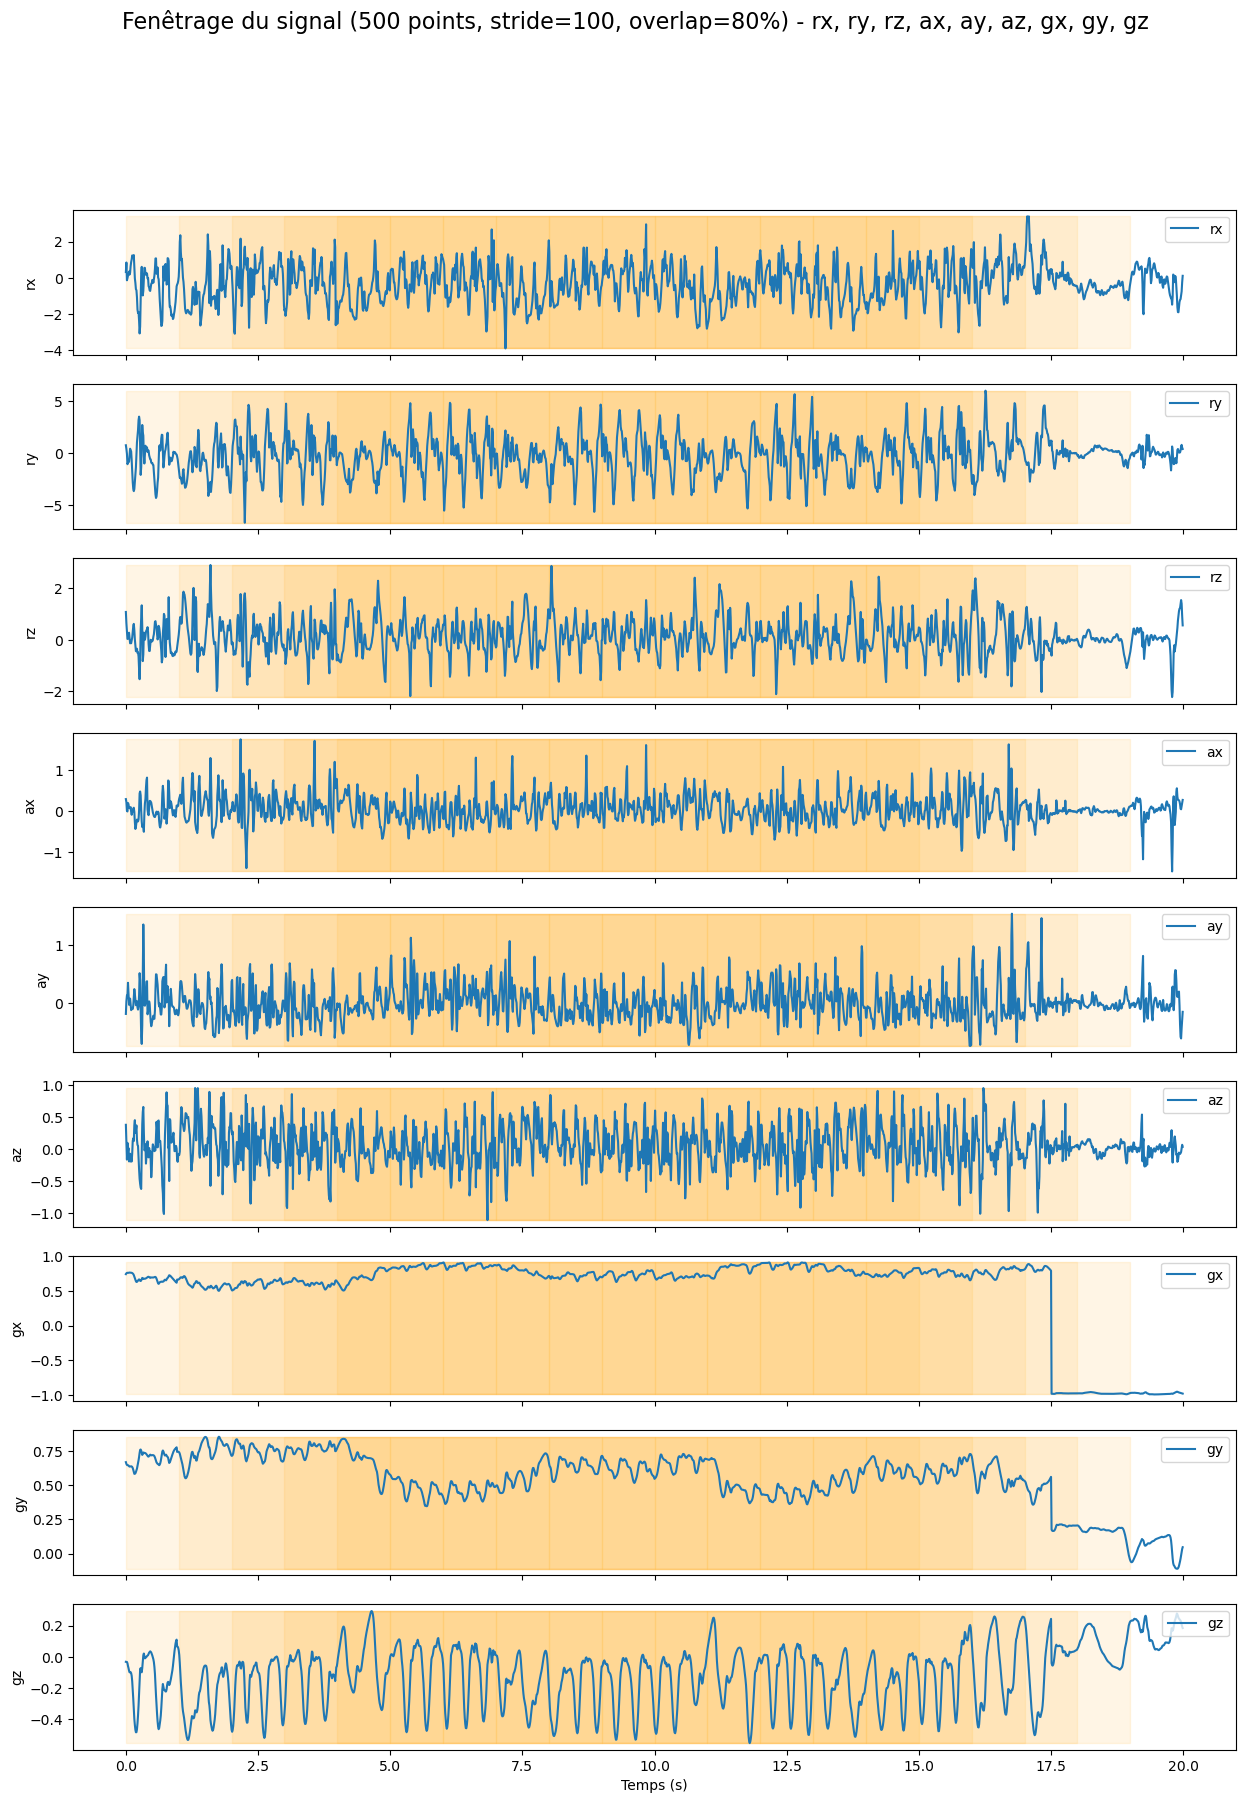

In [10]:
# 4. Création et finalisation du graphique

fig, axes = plt.subplots(9, 1, figsize=(15, 20), sharex=True)
names = ['rx','ry','rz','ax','ay','az','gx','gy','gz']

# Boucle sur chaque signal pour le tracer et surligner les fenêtres
for i in range(9):
    axes[i].plot(time, signals[:, i], label=names[i])
    axes[i].set_ylabel(names[i])
    axes[i].legend(loc="upper right")
    
    # Surlignage des fenêtres
    for start in range(0, n_points - window_size, stride):
        rect = plt.Rectangle((time[start], min(signals[:,i])),
                             5, max(signals[:,i]) - min(signals[:,i]),
                             color="orange", alpha=0.1)
        axes[i].add_patch(rect)

# Axe des abscisses et titre global
axes[-1].set_xlabel("Temps (s)")
plt.suptitle("Fenêtrage du signal (500 points, stride=100, overlap=80%) - rx, ry, rz, ax, ay, az, gx, gy, gz", fontsize=16)
plt.show()
